# CNN Autoencoder

In [2]:
from keras.layers import Input, Dense#, Dropout, BatchNormalization, Reshape
from keras.models import Model
#from keras.regularizers import l2
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import pickle
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# PATH = '/Users/federicomatteo/Downloads/track_all_correct/'
DirList = os.listdir("/Users/federicomatteo/Downloads/track_all_correct") # cartella
MyData = []
for j in range(len(DirList)):
    MyData.append(np.load(Path + DirList[j]))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/federicomatteo/Downloads/track_all_correct'

In [3]:
data = MyData[0][np.newaxis,:,:]
for i in [i for i in range(1, 81) if i != 78]:
    data = np.concatenate((data, MyData[i][np.newaxis,:,:]), axis = 0)

In [4]:
n_total = data.shape[1]

In [5]:
data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

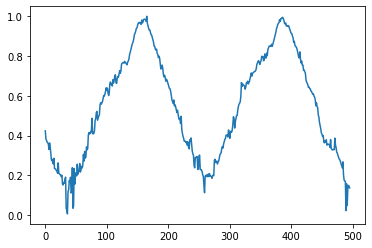

In [6]:
plt.plot(data[0,:,0])

## Data preparation

In [35]:
data_train, data_val = train_test_split(data, test_size=0.2, shuffle=False)

In [36]:
data_val, data_test = data_val[0:10,:,:], data_val[11:16,:,:]

In [38]:
def split_data(data, width, stride):
    
    n = data.shape[0]
    data_ = [data[start_pos:start_pos+width,:] for start_pos in range(0, n-width+1, stride)]
    
    return np.stack((data_), axis=0)

In [39]:
def MergeData(data):
    prova = [split_data(data[i,:,:], 15, 5) for i in range(data.shape[0])]
    prova = np.stack((prova), axis=0)
    data_new = prova[0,:,:,:]
    for i in range(1, prova.shape[0]):
        data_new = np.concatenate((data_new, prova[i,:,:,:]), axis = 0)
    return data_new

In [41]:
x_train = MergeData(data_train)
x_val = MergeData(data_val)
x_test = MergeData(data_test)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(6208, 15, 3)
(970, 15, 3)
(485, 15, 3)


## Architecture Definition

In [12]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from keras.layers import MaxPooling2D, UpSampling2D, Conv2DTranspose

In [13]:
# -- CNN architecture
# This is the input placeholder
input_seq = Input(shape=(15, 3, 1))

X = Conv2D(filters = 4, kernel_size=[4,3], padding='valid', activation='tanh', strides=1)(input_seq)
X = Reshape((12,4,))(X)

X = MaxPooling1D(pool_size=2, strides=None)(X)

X = Flatten()(X)

encoded = Dense(6, activation='tanh')(X)

X = Dense(24, activation='tanh')(encoded)

X = Reshape((6, 1, 4,))(X)

X = UpSampling2D(size=(2,1))(X)

decoded = Conv2DTranspose(filters = 1, kernel_size = [4,3], padding='valid', activation='tanh', strides=1)(X)

decoded = Reshape((15, 3, 1))(decoded)

# This model maps an input to its reconstruction (hopefully denoised)
autoencoder = Model(input_seq, decoded)

autoencoder.compile(optimizer='adam', loss= "mean_absolute_error")

In [60]:
# -- CNN architecture
# This is the input placeholder
input_seq = Input(shape=(15, 3, 1))

X = Conv2D(filters = 4, kernel_size=[4,3], padding='valid', activation='tanh', strides=1)(input_seq)
X = Reshape((12,4,))(X)

X = MaxPooling1D(pool_size=2, strides=None)(X)

X = Flatten()(X)

encoded = Dense(6, activation='tanh')(X)

X = Dense(24, activation='tanh')(encoded)

X = Reshape((6, 1, 4,))(X)

X = UpSampling2D(size=(2,1))(X)

decoded = Conv2DTranspose(filters = 1, kernel_size = [4,3], padding='valid', activation='tanh', strides=1)(X)

decoded = Reshape((15, 3, 1))(decoded)

# This model maps an input to its reconstruction (hopefully denoised)
autoencoder = Model(input_seq, decoded)

autoencoder.compile(optimizer='adam', loss= "mean_absolute_error")

In [61]:
autoencoder.summary()
#plot_model(autoencoder, show_shapes=True, to_file='FFNN.png', rankdir='LR', show_layer_names=False) #TB o LR

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 15, 3, 1)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 1, 4)          52        
_________________________________________________________________
reshape_38 (Reshape)         (None, 12, 4)             0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 6, 4)              0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 24)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 6)                 150       
_________________________________________________________________
dense_26 (Dense)             (None, 24)                168 

## Model Training

In [62]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history = autoencoder.fit(x_train.reshape((6208, 15, 3, 1)), x_train.reshape((6208, 15, 3, 1)),
                epochs=20, # 250
                steps_per_epoch = 100,
                shuffle = True,
                batch_size=None,
                validation_data=(x_val.reshape((970, 15, 3, 1)), x_val.reshape((970, 15, 3, 1))),
                callbacks = [es],
                validation_steps = 1
               )

Train on 6208 samples, validate on 970 samples
Epoch 1/20
100/100 [==============================] - 2s 17ms/step - loss: 0.3319 - val_loss: 0.2283
Epoch 2/20
100/100 [==============================] - 2s 15ms/step - loss: 0.2120 - val_loss: 0.1926
Epoch 3/20
100/100 [==============================] - 2s 16ms/step - loss: 0.1552 - val_loss: 0.1187
Epoch 4/20
100/100 [==============================] - 2s 16ms/step - loss: 0.1004 - val_loss: 0.0916
Epoch 5/20
100/100 [==============================] - 2s 16ms/step - loss: 0.0851 - val_loss: 0.0819
Epoch 6/20
100/100 [==============================] - 2s 17ms/step - loss: 0.0774 - val_loss: 0.0761
Epoch 7/20
100/100 [==============================] - 2s 17ms/step - loss: 0.0724 - val_loss: 0.0720
Epoch 8/20
100/100 [==============================] - 2s 16ms/step - loss: 0.0688 - val_loss: 0.0688
Epoch 9/20
100/100 [==============================] - 2s 16ms/step - loss: 0.0658 - val_loss: 0.0660
Epoch 10/20
100/100 [=======================

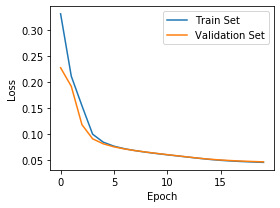

In [63]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper right')
plt.tight_layout()
plt.show()
#plt.savefig('history.png')

## Prediction on Test Set

In [22]:
for i_predict in range(10):
    x_predict = autoencoder.predict(x_test[i_predict,:].reshape((1, 15, 3, 1))).reshape(15,3)
 

    print("fig {}".format(i_predict +1))
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.ylabel(''); plt.xlabel('time')
    #plt.ylim(dim)
    ax.scatter(range(x_train.shape[1],), x_predict[:,0], marker='o')
    ax.scatter(range(x_train.shape[1],), x_test[i_predict][:,0], marker='^')
    
    plt.show()

ValueError: cannot reshape array of size 3 into shape (1,15,3,1)

In [ ]:
x_predict.shape
data_test.shape

In [ ]:
data_test.shape

## Windows Merging

In [ ]:
def comeback_to_data(x_test, fact):
    if fact > 1:
        return "fact must be lower than 1"
    x_test_ = []
    x_test_.append(np.array([x_test[i,:-1] for i in range(0, 15)]))
    for j in range(1, 18):
        x_test_.append(np.array([x_test[i,:] for i in range(int(x_test.shape[0]*j*), int(x_test.shape[0]*(j+1)*fact))]))
      
    return np.concatenate((x_test_), axis=1)

In [ ]:
x_total = []
for time in range(18):
    

In [ ]:
x_predict = []
for i_predict in range(x_val.shape[0]):
    x_predict.append(autoencoder.predict(x_val[i_predict,:].reshape((1,x_val.shape[1], 3, 1))))

x_predict = np.concatenate((x_predict), axis = 0)

x_predict = comeback_to_data(x_predict, 1)

In [ ]:
x_train = comeback_to_data(x_train, windows**-1)
x_test = comeback_to_data(x_test, windows**-1)
print(x_train.shape); print(x_test.shape)

## Final Denoised Series

In [ ]:
for j in range(x_test.shape[0]):
    dim = (0, 1)
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(111)
    plt.ylabel(''); plt.xlabel('time')
    #plt.ylim(dim)
    #ax.scatter(range(x_train.shape[1],), x_predict[j,:], marker='o')
    ax.plot(x_predict[j,:], linewidth = 2.5, c='orange')
    ax.scatter(range(x_train.shape[1],), x_test[j,:], marker='^')
    ax.set_ylabel("distance (m)")
    plt.title("Test set n. {}".format(j+1))